In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [5]:
# Load the model
model_path = 'resnet18_organamnist.pt'
num_classes = len(info['label'])
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Evaluate the model
model.eval()
y_true = []
y_score = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_true.extend(target.cpu().numpy().flatten())
        y_score.extend(output.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

In [7]:
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_score)
print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}')

AUC: 0.984, Accuracy: 0.870


In [8]:
# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, np.argmax(y_score, axis=1))
print(f'Balanced Accuracy: {balanced_acc:.3f}')

Balanced Accuracy: 0.866


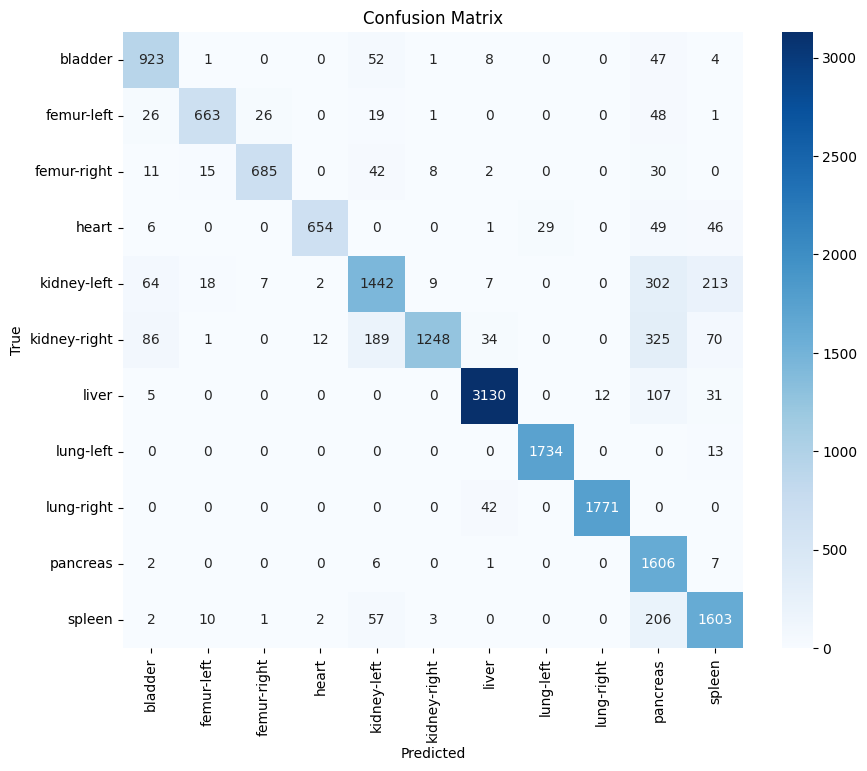

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_score.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
y_prob = np.array(F.softmax(torch.tensor(y_score), dim=1))

/tmp/ipykernel_707467/90981311.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_score), dim=1))


In [11]:
y_prob

array([[3.3185367e-07, 6.4043746e-07, 1.0459815e-08, ..., 1.5133484e-09,
        9.9997115e-01, 3.1425163e-06],
       [9.9995005e-01, 1.1318004e-07, 1.4969346e-07, ..., 2.4306431e-07,
        3.0856602e-06, 3.7921218e-05],
       [1.1648526e-06, 7.2006628e-07, 7.4874544e-07, ..., 9.9993539e-01,
        9.3257199e-07, 7.7102203e-07],
       ...,
       [4.7641643e-04, 5.1523169e-04, 9.5892778e-05, ..., 1.3471651e-04,
        9.1744453e-01, 5.5493448e-02],
       [4.2355635e-09, 4.2398312e-09, 1.3409656e-11, ..., 1.1043233e-12,
        9.9999952e-01, 3.8503512e-07],
       [2.4599411e-05, 6.7622939e-05, 1.0800155e-05, ..., 2.4883839e-04,
        4.0208997e-05, 3.8378910e-04]], dtype=float32)

In [12]:
distances = uq.distance_to_hard_labels_computation(y_prob)

In [13]:
correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_score[i])]
incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_score[i])]

/mnt/data/psteinmetz/archive_notebooks/Documents/UQ_toolbox.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y=y_title, data=df, palette='muted')


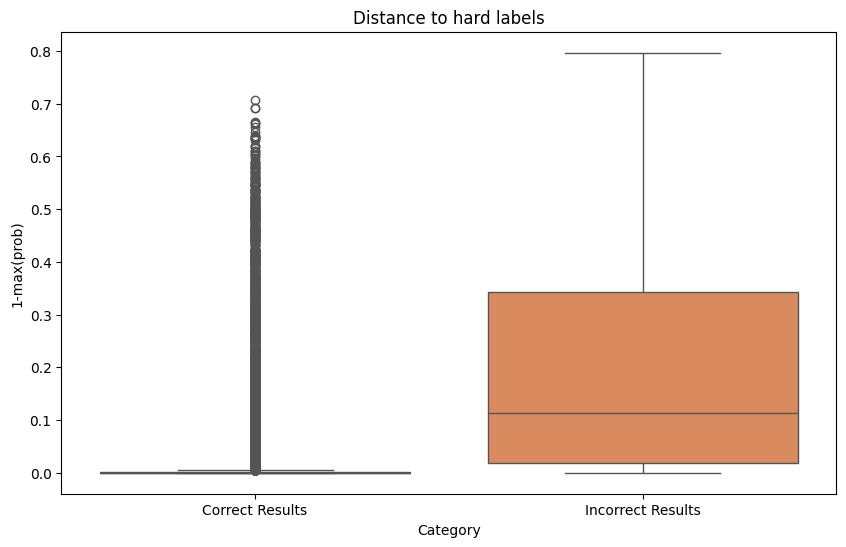

In [14]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Distance to hard labels', swarmplot=False)

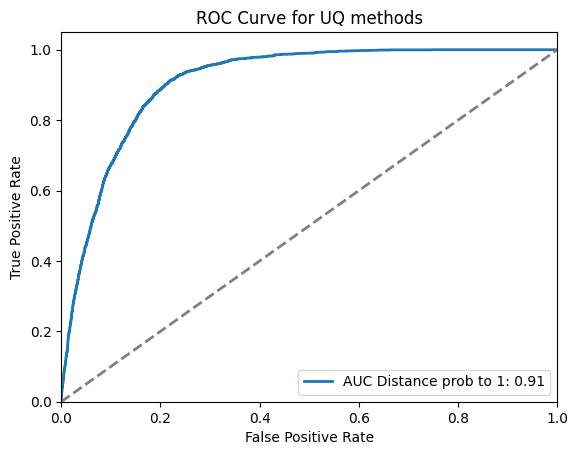

In [16]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1'], [fpr_distance_to_hard_labels], [tpr_distance_to_hard_labels], [auc_distance_to_hard_labels])